In [1]:
%matplotlib nbagg
import numpy as np
import json
import os, math
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from IPython.display import clear_output, display

from alvra_tools.load_data import *
from alvra_tools.load_meta import *
from alvra_tools.channels import *
#from alvra_tools.channels_raw import *
from alvra_tools.utils import errfunc_sigma, errfunc_fwhm, threshold
import glob
from ipyfilechooser import FileChooser

In [18]:
fc = FileChooser('/sf/alvra/data/p18180/raw/scan_info/')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p18180/raw/scan_info', filename='', show_hidden='False')

In [28]:
quantile_band = 0.2

channel_list = [channel_Izero117, channel_energy]

###############################################################3
json_file = fc.selected
#json_file = DIR_json + scan_name + scan_range + ".json"
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 1

print ("Processing",numFiles,"files")

Spectrum_PSSS = []
PSSS_eV =[]
Izero = []
Energy_eV = []

for i in range(0,numFiles):
    filename = str(data['scan_files'][i][1])
    print (filename)
    exists = os.path.isfile(filename)
    if exists:# and i!=80:
        clear_output(wait=True)
        print("step", i+1, "of",numFiles, f": Processing {filename}")
        
        results = load_data_compact(channel_list, filename)
        
        #(data_trans_shot, data_fluo_shot, Izero_shot, laser_shot, Energy_shot, pulseIDs) = load_FEL_scans(filename, channel_energy)
        
        Izero_shot = results[channel_Izero117]
        Energy_shot = results[channel_energy]
 
        df_Izero = pd.DataFrame(Izero_shot)
        Izero.append(np.quantile(df_Izero, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))
    
        Energy_shot = [x for x in Energy_shot if (np.abs(x) > 0)]
        Energy_eV.append(np.mean(Energy_shot))
        

PSSS_eV = np.asarray(PSSS_eV)
Spectrum_PSSS = np.asarray(Spectrum_PSSS)
Izero = np.asarray(Izero)

Energy_eV_readback = load_scan_readback(json_file)
Energy_eV = np.asarray(Energy_eV)
print ("Job done!")
print ('Quantiles for error bars: {},{}'.format(0.5 - quantile_band/2, 0.5 + quantile_band/2))

step 31 of 31 : Processing /sf/alvra/data/p18180/raw/scan_data/monoscan_2.45_2/run_000275.BSDATA.h5

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet           251 / 251 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS117:INTENSITY         251 / 251 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LTIM01-EVR0:DUMMY_PV4_NBS 251 / 251 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 251 / 251 -> 0% loss
complete channels: 3 / 3 -> 0% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Job done!
Quantiles for error bars: 0.4,0.6


In [29]:
# Normalization in case the signal comes from a Diode after I0.

#Signal_norm = -Signal / Izero

# No normalization in case the signal comes from I0 itself.

Signal_norm = Izero

<IPython.core.display.Javascript object>


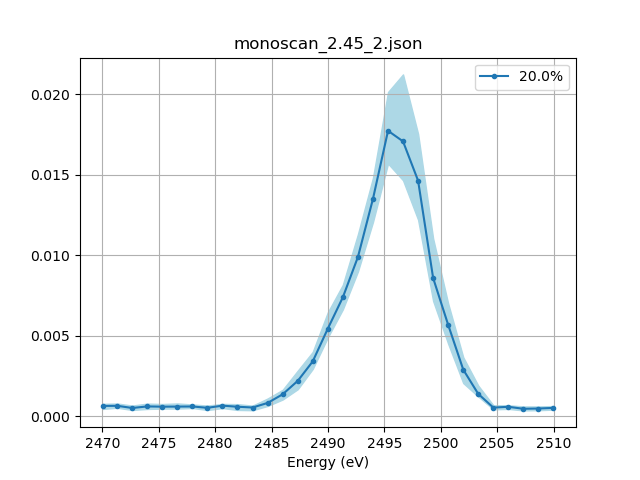

In [30]:
Int = Signal_norm[:,0]
err_low = Signal_norm[:,1]
err_high = Signal_norm[:,2]

plt.figure()

plt.plot(Energy_eV, Int, label='{}%'.format(quantile_band*100),marker='.')
plt.fill_between(Energy_eV, err_low, err_high, color='lightblue')

plt.title(fc.selected_filename)
plt.xlabel("Energy (eV)")
plt.legend(loc="best")
plt.grid()

plt.show()

In [ ]:
spectrum_toFit = np.copy(Signal_norm[:,0])
Energy_eV_toFit = np.copy(Energy_eV.ravel())

def gaussian(x, amp, cen, wid):
    return amp * np.exp(-4*(np.log(2))*(x-cen)**2 / wid**2)

# Now fit with error funciton
index = ~(np.isnan(Energy_eV_toFit) | np.isnan(spectrum_toFit))

parameters,extras = curve_fit(gaussian, Energy_eV_toFit[index], spectrum_toFit[index], p0 = [0.3, 2400, 7])
#parameters,extras = curve_fit(errfunc_fwhm, Delay_mm_toFit, Pump_probe_toFit, p0 = [0.01, 0.12, 161, 0.1])

print("Position t0 =",np.round(parameters[1],3),"eV")
print("Width =",np.abs(np.round(parameters[2],3)),"eV")

#best_vals, covar = curve_fit(gaussian, x, y, p0=init_vals)

In [ ]:
plt.figure()

plt.plot(Energy_eV, Int, label='{}%'.format(quantile_band*100),marker='.')
plt.fill_between(Energy_eV, err_low, err_high, color='lightblue')

plt.plot(Energy_eV_toFit, gaussian(Energy_eV_toFit,*parameters))

plt.title(scan_name + scan_range)
plt.grid()
plt.xlabel("Energy (eV)")
plt.legend(loc="best")


plt.show()

In [ ]:
Signal_norm1 = Signal_norm.copy()

In [ ]:
plt.figure()

plt.plot(Energy_eV, Signal_norm_1, label="original",marker='.')
plt.plot(Energy_eV, Signal_norm_3, label="first try",marker='.')
plt.plot(Energy_eV, Signal_norm_2, label="second try",marker='.')

low_err= Signal_norm - err_Signal_norm
high_err= Signal_norm + err_Signal_norm


#plt.fill_between(Energy_eV, low_err, high_err, color='lightblue')
plt.title(DIR)
plt.xlabel("Energy (eV)")
plt.legend(loc="best")


plt.show()
#plt.savefig('Timescan_7_diode')